# Ecuaciones de Cinética Puntual

## Ecuaciones de cinética de un reactor nuclear

Las ecuaciones de cinética puntual del núcleo de un reactor a un grupo de energía y a un grupo de precursores sin fuente de neutrones son:

$$
\begin{eqnarray}
\frac{dn(t)}{dt}&=&\frac{\rho(t)-\beta}{\Lambda}n(t)+\lambda c(t)\\
\frac{dc(t)}{dt}&=&\frac{\beta}{\Lambda}n(t)-\lambda c(t)
\end{eqnarray}
$$

con $n$ el flujo neutrónico normalizado (en realidad es población de neutrones, pero bajo ciertas condiciones se puede considerar proporcional al flujo neutrónico o potencia nuclear), $c$ la concentración de precursores, y $\rho$ la reactividad introducida en el mismo por las barras de control. Los parámetros del sistema son: $\Lambda = 1,76e^{-4} s$ (tiempo de reproducción de los neutrones rápidos), $\lambda = 0,076 1/s$ (constante de decaimiento de los precursores) y $\beta = 765$pcm (fracción de neutrones retardados que son emitidos por los precursores).

In [1]:
import sympy as sp
sp.init_printing()
n, r, b, L, l, c = sp.symbols('n, rho, beta, Lambda, lambda, c')

Definimos las ecuaciones de estados, es decir, las derivadas de las variables de estados en función de los estados y las entradas.

In [2]:
dn=(r-b)/L*n+l*c
dn

In [3]:
dc=b/L*n-l*c
dc

Ahora le decimos a sympy que lo represente en forma matricial:

In [4]:
s=sp.Matrix([dn,dc]) #las ecuaciones de estados
s

⎡      n⋅(-β + ρ)⎤
⎢c⋅λ + ──────────⎥
⎢          Λ     ⎥
⎢                ⎥
⎢          β⋅n   ⎥
⎢   -c⋅λ + ───   ⎥
⎣           Λ    ⎦

In [5]:
x=sp.Matrix([n,c]) #definimos el vector de estados
x

⎡n⎤
⎢ ⎥
⎣c⎦

In [6]:
u=sp.Matrix([r]) #definimos el vector de entradas
u

[ρ]

## Linealización utilizando SymPy

Recordando la función Jacobiano, podemos valernos de esta para linealizar el sistema

In [7]:
A=s.jacobian(x) # la matriz A del espacio de estados
B=s.jacobian(u) #la matriz B del espacio de estados

In [8]:
A

⎡-β + ρ    ⎤
⎢──────  λ ⎥
⎢  Λ       ⎥
⎢          ⎥
⎢  β       ⎥
⎢  ─     -λ⎥
⎣  Λ       ⎦

In [9]:
B

⎡n⎤
⎢─⎥
⎢Λ⎥
⎢ ⎥
⎣0⎦

Finalmente evaluamos las matrices A y B en los valores de los parámetros que tenemos dados.

In [10]:
A.subs([(l, 0.076), (b,765e-5),(L,1.76e-4)])

⎡5681.81818181818⋅ρ - 43.4659090909091  0.076 ⎤
⎢                                             ⎥
⎣          43.4659090909091             -0.076⎦

In [11]:
B.subs([(l, 0.076), (B,765e-5),(L,1.76e-4)])

⎡5681.81818181818⋅n⎤
⎢                  ⎥
⎣        0         ⎦

Para obtener el punto de equilibrio, suponemos que trabajaremos alrededor de $n=1$, y lo que se hace es igualar a cero las ecuaciones de la derivada.

In [12]:
s2=s.subs([(l, 0.076), (b,765e-5),(L,1.76e-4),(n,1)])
sol0=sp.solve(s2,(c,r))

In [13]:
c0=sol0[c]
r0=sol0[r]

In [14]:
An=A.subs([(l, 0.076), (b,765e-5),(L,1.76e-4),(n,1),(r,r0),(c,c0)])
Bn=B.subs([(l, 0.076), (b,765e-5),(L,1.76e-4),(n,1),(r,r0),(c,c0)])

## Simulación numérica

In [15]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# %matplotlib qt5  # descomentar para ver las figuras en ventanas emergentes

In [16]:
l=0.076
b=765e-5
L=1.76e-4
n0=1

In [17]:
def dx(t,x):
    n=x[0]
    c=x[1]
    r= r0 if t<0 else r0 -10e-5 #1000pcm para poner un valor
    dn=(r-b)/L*n+l*c
    dc=b/L*n-l*c
    return ([dn,dc])

In [18]:
sol = solve_ivp(dx, (0,7), (n0,c0), method='BDF')
t= sol.t
n=sol.y[0]
c=sol.y[1]

La simulación dinámica del sistema lineal la podemos hacer usando directamente el módulo de control.

In [19]:
import control as ctrl
import numpy as np

In [20]:
Cn=np.eye(2)
Dn=np.zeros((2,1))

In [21]:
sys = ctrl.ss(An,Bn,Cn,Dn)
t2,y2 = ctrl.step_response(sys, T=np.linspace(0,7,1001))

Entonces ahora podemos visualizar los resultados en las siguientes figuras:

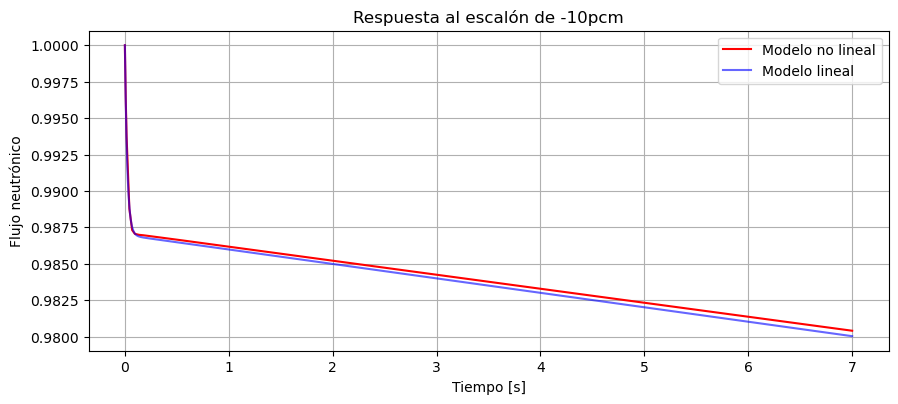

In [22]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,n,'r', label='Modelo no lineal')
ax.plot(t2,(y2[0,:]*-10e-5+n0).T,'b', alpha=0.6, label='Modelo lineal')
ax.grid()
ax.legend()
ax.set_title('Respuesta al escalón de -10pcm')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Flujo neutrónico');

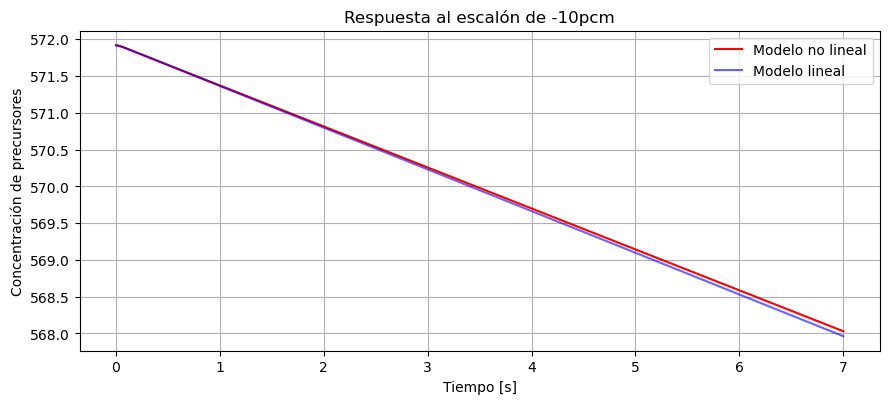

In [23]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,c,'r', label='Modelo no lineal')
ax.plot(t2,(y2[1,:]*-10e-5+c0).T,'b', alpha=0.6, label='Modelo lineal')
ax.grid()
ax.legend()
ax.set_title('Respuesta al escalón de -10pcm')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Concentración de precursores');

Vemos que el sistema linealizado es una muy buena aproximación del no lineal. Esto es por que la perturbación de 10pcm es suficientemente chica y el sistema no se aleja demasiado del punto del cual linealizamos.

## Probemos aumentado un poco más la reactividad de entrada a 200 pcm

In [24]:
def dx(t,x):
    n=x[0]
    c=x[1]
    r= r0 if t<0 else r0 -200e-5 #1000pcm para poner un valor
    dn=(r-b)/L*n+l*c
    dc=b/L*n-l*c
    return ([dn,dc])

In [25]:
sol = solve_ivp(dx, (0,7), (n0,c0), method='BDF')
t= sol.t
n=sol.y[0]
c=sol.y[1]

Y los resultados los vemos en las siguientes gráficas:

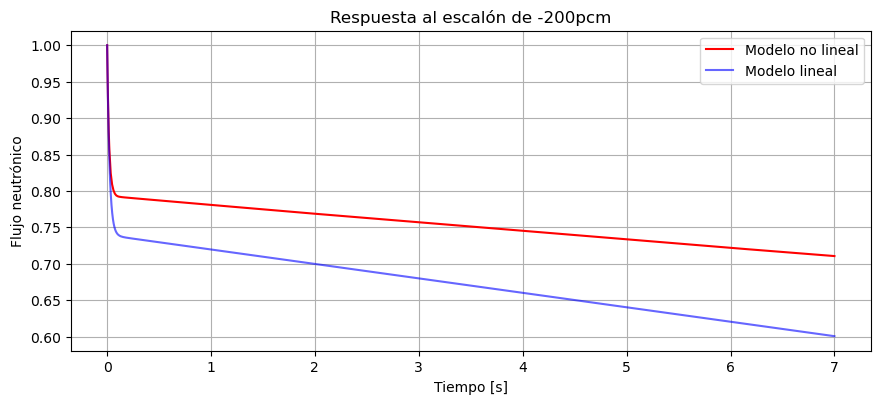

In [26]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,n,'r', label='Modelo no lineal')
ax.plot(t2,(y2[0,:]*-200e-5+n0).T,'b', alpha=0.6, label='Modelo lineal')
ax.grid()
ax.set_title('Respuesta al escalón de -200pcm')
ax.set_xlabel('Tiempo [s]')
ax.legend()
ax.set_ylabel('Flujo neutrónico');

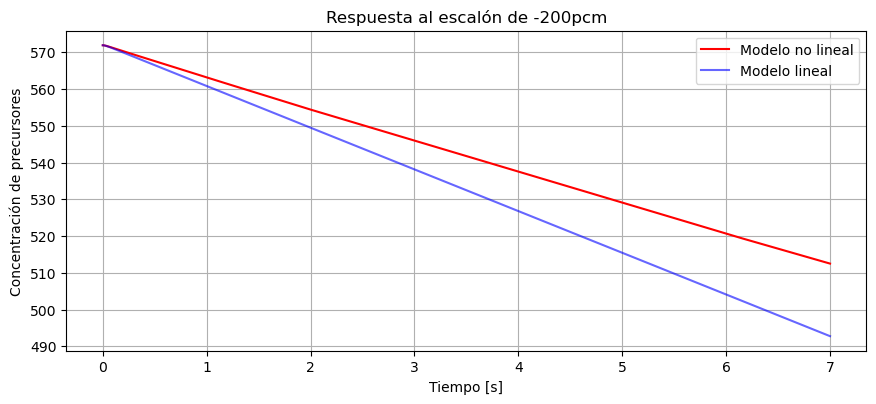

In [27]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,c,'r', label='Modelo no lineal')
ax.plot(t2,(y2[1,:]*-200e-5+c0).T,'b', alpha=0.6, label='Modelo lineal')
ax.grid()
ax.set_title('Respuesta al escalón de -200pcm')
ax.set_xlabel('Tiempo [s]')
ax.legend()
ax.set_ylabel('Concentración de precursores');

Vemos como ahora la aproximación es bastante peor a la que teníamos cuando lo perturbamos con 10 pcm.